# PROTOTYPE SHAPE OPTIMIZATION: optimizing element area for stresses (max stress) and for forbidden frequency band - 1dof elements (rod)

## Modal analysis of 1D rod with consistent mass matrix

In [8]:
import fem_toolbox as ft

# read geometry

nodes_coords_beam, beam_connectivity, beam_crossSections, mat_properties = ft.geometry.read_structure("../shape_optimization/geom/myrod.txt")

# meshing
elements_per_beam = 10

fem_nodes, fem_elements, element_crossSections = ft.mesh.discretize(nodes_coords_beam, beam_connectivity, beam_crossSections, elements_per_beam=elements_per_beam)

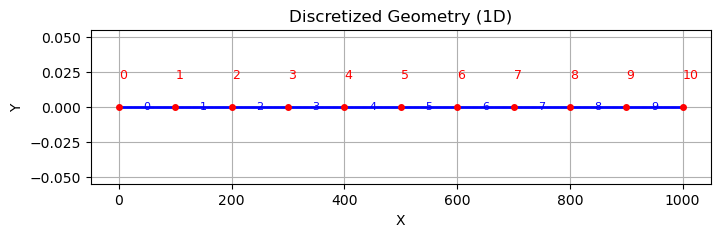

In [9]:
ft.mesh.plot_discretized_geometry_1D(nodes_coords_beam, beam_connectivity, fem_nodes, fem_elements)

In [10]:
# TYPE OF ELEMENT: ROD
ndof_per_node = 1

In [11]:
# read BC and forces
_ , bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values = ft.BC_loads.read_bc_and_forces("../shape_optimization/geom/myrodBC.txt")

print(bc_nodes)
print(bc_dofs)
print(bc_values)

# validate constraints (read docs)
num_nodes= fem_nodes.shape[0]
ft.BC_loads.validate_constraints(num_nodes, ndof_per_node, bc_nodes, bc_dofs)

[0]
[0]
[0.0]
Constraint check passed: 1 DOFs constrained out of 11.


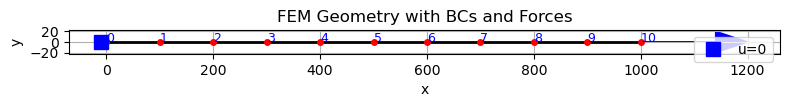

In [12]:
# visual validation before solving 
ft.BC_loads.plot_fem_model(fem_nodes, fem_elements, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, scale_force=0.2)

In [13]:
# assemble global mass matrix rod
local_m_matrix = ft.elements.m_rod
local_k_matrix = ft.elements.k_rod
rotation_matrix = None 

M_global = ft.femsolver.assembleM(local_m_matrix, rotation_matrix, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)

K_global = ft.femsolver.assembleK(local_k_matrix, rotation_matrix, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)

# assemble global force vector
num_dofs = M_global.shape[0]
f_ext = ft.femsolver.build_force_vector(f_nodes, f_dofs, f_values, num_dofs, ndof_per_node)


In [14]:
# Modal analysis
print(f"\nBoundary conditions: {bc_dofs}\n")

frequencies, mode_shapes, free_dofs = ft.femsolver.modal_analysis(K_global, M_global, bc_nodes, bc_dofs, ndof_per_node, num_modes = 3, verbose=True)

# static analysis (for checking purposes)
u = ft.femsolver.static_analysis(K_global, f_ext, bc_nodes, bc_dofs, bc_values, ndof_per_node)

print(f"\nNodal displacements: {u}")


Boundary conditions: [0]

Mode 1: 40.93 Hz
Mode 2: 123.81 Hz
Mode 3: 209.74 Hz

Nodal displacements: [0.         0.00146972 0.00293945 0.00440917 0.00587889 0.00734862
 0.00881834 0.01028807 0.01175779 0.01322751 0.01469724]


In [15]:
# post processing stresses
cross_section = "rectangle"

stress_max, stress_axial, stress_bending, stress_shear, von_mises_stress, internal_actions = ft.postprocessing.eval_stress(ft.elements.k_rod, None, u,fem_elements, fem_nodes, element_crossSections, mat_properties, cross_section, ndof_per_node=1)

print(stress_axial)



[3.08641975 3.08641975 3.08641975 3.08641975 3.08641975 3.08641975
 3.08641975 3.08641975 3.08641975 3.08641975]


In [16]:
# NOT WORKING AT THE MOMENT -> INTERNAL ACTIONS PLOT FOR BAR ELEMENT
#ft.postprocessing.plot_internal_actions_1D(fem_nodes, fem_elements, internal_actions, dof_per_node=1)

DOF 0: Reaction force = -1000.00 N


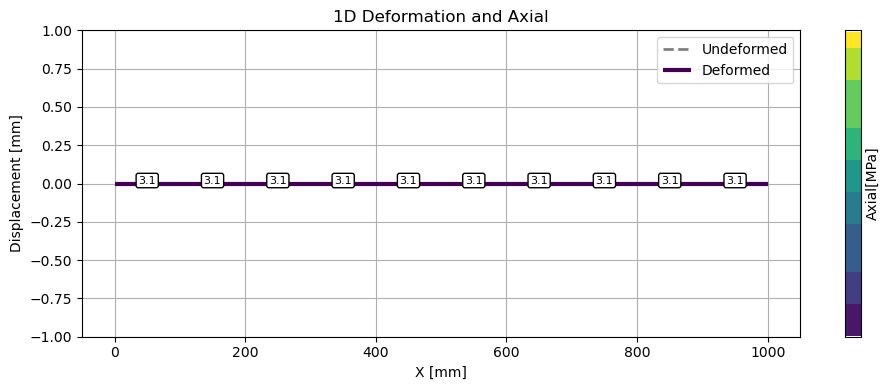

In [17]:
# plotting things to confirm results

reactions, _ = ft.postprocessing.compute_reaction_forces(K_global, u, bc_nodes, bc_dofs, ndof_per_node)

stress_type = "axial"
ft.postprocessing.plot_1d_loaded_structure(fem_nodes, fem_elements, u, stress_axial, stress_type=stress_type, ndof_per_node = ndof_per_node, scale=1, show_labels=True)

In [18]:
#ft.postprocessing.animate_mode_shape_1D(mode_index=0, eigenvecs=mode_shapes, node_coords=fem_nodes, free_dofs=free_dofs, K=K_global, elements=fem_elements, ndof_per_node=1)

In [19]:
#ft.postprocessing.animate_mode_shape_1D(mode_index=1, eigenvecs=mode_shapes, node_coords=fem_nodes, free_dofs=free_dofs, K=K_global, elements=fem_elements, ndof_per_node=1)

## TRIAL ADJOINT CALCULATION (otherwise use finite-differences for now)

In [20]:
# adjoint calculation for stresses
import numpy as np
from scipy.sparse.linalg import spsolve




def compute_stress_constraint_gradients_adjoint(
    A_list,
    element_crossSections,
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node,
    bc_nodes,
    bc_dofs,
    f_nodes,
    f_dofs,
    f_values,
    assembleK,
    assembleF,
    compute_stresses,
    k_local_func,
    rotation_func=None
):
    num_elements = len(fem_elements)
    original_inertias = [e['I'] for e in element_crossSections]
    # la funzione di ottimizzazione manda in giro solo le aree, in un vettore. Dobbiamo ricostruire la lista di dizionari se vogliamo che tutte le funzioni di fem_toolbox lavorino ancora
    #element_areas = [{'A': A, 'I': I} for A, I in zip(A_list, original_inertias)]
    element_areas = element_crossSections

    # Assemble system and solve for displacements
    K = assembleK(k_local_func, rotation_func, fem_nodes, fem_elements,
                  element_areas, mat_properties, ndof_per_node)
    total_dofs = K.shape[0]
    f = assembleF(f_nodes, f_dofs, f_values, total_dofs, ndof_per_node)

    # THIS PROCEDURE IS A REIMPLEMENTATION. SHOULD DO MY FUNCTION

    #total_dofs = K.shape[0]
    #all_dofs = np.arange(total_dofs)
    #constrained_dofs = [node * ndof_per_node + dof for node, dof in zip(bc_nodes, bc_dofs)]

    #free_dofs = np.setdiff1d(all_dofs, constrained_dofs)
   # 
   # K_ff = K[np.ix_(free_dofs, free_dofs)]
   # f_f = f[free_dofs]

   # u_f = spsolve(K_ff, f_f)

   # # Reconstruct full displacement vector
   # u = np.zeros(total_dofs)
   # u[free_dofs] = u_f

    u =  ft.femsolver.static_analysis(K, f, bc_nodes, bc_dofs, bc_values, ndof_per_node)
                                     
    # Compute stresses
    # stress_max, stress_axial, stress_bending, stress_shear, von_mises_stress, internal_actions = ft.postprocessing.eval_stress(ft.elements.k_rod, None, u,fem_elements, fem_nodes, element_crossSections, mat_properties, cross_section, ndof_per_node=1)

    _, stresses, _ , _ , _, _ = ft.postprocessing.eval_stress(k_local_func, rotation_func, u, fem_elements, fem_nodes, element_areas, mat_properties, cross_section, ndof_per_node)   

    #stresses = np.abs(stresses)

    #stresses = compute_stresses(u, fem_nodes, fem_elements, element_areas, mat_properties, ndof_per_node)

    # Initialize gradient matrix: ∂g_i / ∂A_j
    grad_constraints = np.zeros((num_elements, num_elements))

    # Loop over each constraint (one per element)
    for i in range(num_elements):
        # g_i = σ_i - σ_max
        # We want ∂σ_i/∂A_j for all j

        # Step 1: ∂σ_i/∂u
        # Assume your compute_stresses returns an array: σ = S * u
        # So ∂σ_i/∂u is the i-th row of S
        # For now, approximate with finite difference on u (simplified version)
        delta = 1e-8
        d_sigma_du = np.zeros_like(u)

        for d in range(len(u)):     # per tirare fuori S ti servono tanti stati di stress u. Non va bene. INvece che differenze finite usa l'espressione analitca
            u_perturbed = u.copy()
            u_perturbed[d] += delta
            #sigma_perturbed = compute_stresses(u_perturbed, fem_nodes, fem_elements, element_areas, mat_properties, ndof_per_node)
            _, sigma_perturbed, _ , _ , _, _ = ft.postprocessing.eval_stress(k_local_func, rotation_func, u_perturbed, fem_elements, fem_nodes, element_areas, mat_properties, cross_section, ndof_per_node)

            # No abs here
            #d_raw = (sigma_perturbed[i] - stresses[i]) / delta
            #sign = np.sign(stresses[i]) if stresses[i] != 0 else 1.0  # handle zero safely
            #d_sigma_du[d] = -sign * d_raw
  
            #sigma_perturbed = np.abs(sigma_perturbed) 
            d_sigma_du[d] = (sigma_perturbed[i] - stresses[i]) / delta

        # Step 2: Solve adjoint system: K^T * λ = dσ_i/du
        # where dr/du = K
        # Since K is symmetric, use K
        #λ_f = spsolve(K_ff, d_sigma_du[free_dofs])
        #λ = np.zeros_like(u)
        #λ[free_dofs] = λ_f  # adjoint vector
        λ = ft.femsolver.static_analysis(K, d_sigma_du, bc_nodes, bc_dofs, bc_values, ndof_per_node)

        # Step 3: ∂K/∂A_j * u, then multiply with λ^T
        for j in range(num_elements):
            # Perturb area j slightly
            A_perturbed = A_list.copy()
            A_perturbed[j] += delta
            #perturbed_areas = [{'A': A_perturbed[k]} for k in range(num_elements)]
            perturbed_areas = [{'A': A_perturbed[k], 'I': original_inertias[k]} for k in range(num_elements)]


            K_perturbed = assembleK(k_local_func, rotation_func, fem_nodes, fem_elements, perturbed_areas, mat_properties, ndof_per_node)
            dK_dAj = (K_perturbed - K) / delta

            # λ^T * ∂K/∂A_j * u
            grad_constraints[i, j] = λ @ (dK_dAj @ u)

    return grad_constraints


## OPTIMIZATION WITH ADJOINT -> NOT WORKING FOR NOW

import numpy as np
from scipy.optimize import minimize


def objective(A):
    return np.sum(A)

def objective_grad(A):
    return np.ones_like(A)


def shape_optimization_stress_constrained(
    element_crossSections,
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node,
    bc_nodes,
    bc_dofs,
    f_nodes,
    f_dofs,
    f_values,
    assembleK,
    assembleF,
    compute_stresses,
    sigma_max,
    k_local_func,
    rotation_func=None,
    A_min=1e-2,
    A_max=1e4,
    section_shape="rectangle"
):
    num_elements = len(element_crossSections)
    # x0 = np.array([e['A'] for e in element_crossSections])
    original_inertias = [e['I'] for e in element_crossSections]


    def constraint_fun(A):
        # A is a vector of areas (because scipy wants that), but all the functions in fem_toolbox want a dictionary {'A':A, 'I':I}. Need to rebuild this dictionary
        #element_areas = [{'A': A[i]} for i in range(num_elements)]
        element_areas = [{'A': A, 'I': I} for A, I in zip(A, original_inertias)]
        
        # Assemble system and solve
        K = assembleK(k_local_func, rotation_func, fem_nodes, fem_elements,
                      element_areas, mat_properties, ndof_per_node)
        total_dofs = K.shape[0]
        f = assembleF(f_nodes, f_dofs, f_values, total_dofs, ndof_per_node)

#         all_dofs = np.arange(total_dofs)
#         constrained_dofs = [node * ndof_per_node + dof for node, dof in zip(bc_nodes, bc_dofs)]
#         free_dofs = np.setdiff1d(all_dofs, constrained_dofs)
# 
#         K_ff = K[np.ix_(free_dofs, free_dofs)]
#         f_f = f[free_dofs]
#         u_f = np.linalg.solve(K_ff.toarray(), f_f)
# 
#         u = np.zeros(total_dofs)
#         u[free_dofs] = u_f

        u = ft.femsolver.static_analysis(K, f, bc_nodes, bc_dofs, bc_values, ndof_per_node)

        _, axial_stress, _ , _, _, _ = ft.postprocessing.eval_stress(k_local_func, rotation_func, u, fem_elements, fem_nodes, element_areas, mat_properties, section_shape, ndof_per_node)

        axial_stress = np.abs(axial_stress)

        # Constraint: sigma_i - sigma_max <= 0
        # return axial_stress - sigma_max
        # Constraint: sigma_max - sigma_i >= 0
        return sigma_max - axial_stress

    def constraint_jac(A):
        return compute_stress_constraint_gradients_adjoint(
            A,
            element_crossSections,
            fem_nodes,
            fem_elements,
            mat_properties,
            ndof_per_node,
            bc_nodes,
            bc_dofs,
            f_nodes,
            f_dofs,
            f_values,
            assembleK,
            assembleF,
            compute_stresses,
            #sigma_max,
            k_local_func,
            rotation_func
        )

    constraints = {
        'type': 'ineq',
        'fun': constraint_fun,
        'jac': constraint_jac
    }

    bounds = [(A_min, A_max) for _ in range(num_elements)]
    
    # extract only the areas from dictionary since scipy wants an array
    x0 = np.array([e['A'] for e in element_crossSections])

    result = minimize(
        fun=objective,
        x0=x0,
        jac=objective_grad,
        method='SLSQP',
        bounds=bounds,
        constraints=[constraints],
        options={'disp': True, 'maxiter': 100}
    )

    def finite_difference_constraint_grad(A, epsilon=1e-6):
        g0 = constraint_fun(A)
        grad = np.zeros((len(g0), len(A)))
        for j in range(len(A)):
            A_pert = A.copy()
            A_pert[j] += epsilon
            g1 = constraint_fun(A_pert)
            grad[:, j] = (g1 - g0) / epsilon
        return grad


    optimized_areas = result.x
    return optimized_areas

sigma_max = 40

optimized_areas = shape_optimization_stress_constrained(element_crossSections, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, f_nodes, f_dofs, f_values, ft.femsolver.assembleK, ft.femsolver.build_force_vector, ft.postprocessing.eval_stress, sigma_max, ft.elements.k_rod, None, A_min = 10, A_max=10000)


## OPTIMIZATION WITH FINITE DIFFERENCES

In [21]:
from scipy.optimize import minimize
import numpy as np

def shape_optimization_stress_constrained_finite_diff(
    element_crossSections,
    sigma_max,
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node,
    bc_nodes,
    bc_dofs,
    bc_values,
    f_nodes,
    f_dofs,
    f_values,
    assembleK,
    assembleF,
    k_local_func,
    rotation_func=None,
    A_min=1e-2,
    A_max=1e4,
    section_shape="rectangle"
):
    num_elements = len(element_crossSections)
    original_inertias = [e['I'] for e in element_crossSections]

    def objective(A):
        return np.sum(A)

    def constraint_fun(A):
        # Convert back A vector to list of dictionaries (all fem_toolbox functions work with that)
        element_areas = [{'A': A[i], 'I': original_inertias[i]} for i in range(num_elements)]

        # Assemble stiffness matrix and force vector
        K = assembleK(k_local_func, rotation_func, fem_nodes, fem_elements,
                      element_areas, mat_properties, ndof_per_node)
        total_dofs = K.shape[0]
        f = assembleF(f_nodes, f_dofs, f_values, total_dofs, ndof_per_node)

        # Solve static system
        u = ft.femsolver.static_analysis(K, f, bc_nodes, bc_dofs, bc_values, ndof_per_node)

        # Evaluate stresses
        _, axial_stress, _, _, _, _ = ft.postprocessing.eval_stress(
            k_local_func, rotation_func, u, fem_elements, fem_nodes,
            element_areas, mat_properties, section_shape, ndof_per_node
        )

        # Constraint: σ_i <= σ_max ⇒ σ_max - σ_i >= 0
        return sigma_max - np.abs(axial_stress)

    # Define bounds and constraints for SLSQP
    bounds = [(A_min, A_max) for _ in range(num_elements)]
    constraints = {
        'type': 'ineq',
        'fun': constraint_fun  # if I don't give jacobian, SciPy estimates it via finite differences
    }

    x0 = np.array([e['A'] for e in element_crossSections])

    result = minimize(
        fun=objective,
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints=[constraints],
        options={'disp': True, 'maxiter': 100}
    )

    return result.x


In [22]:
sigma_max = 40

optimized_areas_fd  = shape_optimization_stress_constrained_finite_diff(element_crossSections, sigma_max, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, ft.femsolver.assembleK, ft.femsolver.build_force_vector, ft.elements.k_rod, None, A_min = 10, A_max=10000)

print(optimized_areas_fd)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 250.00000000025997
            Iterations: 13
            Function evaluations: 146
            Gradient evaluations: 13
[25. 25. 25. 25. 25. 25. 25. 25. 25. 25.]


In [23]:
print(optimized_areas_fd)
print(element_crossSections)

[25. 25. 25. 25. 25. 25. 25. 25. 25. 25.]
[{'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}]


## Stress opt. verification from scratch

In [24]:
# Recalculate stresses with optimized areas
original_inertias = [e['I'] for e in element_crossSections]
optimized_element_data = [{'A': A, 'I': I} for A, I in zip(optimized_areas_fd, original_inertias)]


k_local_func = ft.elements.k_rod
rotation_func = None
assembleF = ft.femsolver.build_force_vector
section_shape = "rectangle"

K_opt = ft.femsolver.assembleK(k_local_func, rotation_func, fem_nodes, fem_elements, optimized_element_data, mat_properties, ndof_per_node)
f_opt = assembleF(f_nodes, f_dofs, f_values, K_opt.shape[0], ndof_per_node)
u_opt = ft.femsolver.static_analysis(K_opt, f_opt, bc_nodes, bc_dofs, bc_values, ndof_per_node)
_, axial_stress, *_ = ft.postprocessing.eval_stress(k_local_func, rotation_func, u_opt, fem_elements, fem_nodes, optimized_element_data, mat_properties, section_shape, ndof_per_node)

print("Axial stresses:", axial_stress)
print("Max allowed stress:", sigma_max)


Axial stresses: [40. 40. 40. 40. 40. 40. 40. 40. 40. 40.]
Max allowed stress: 40


## Trying out a function for having a look at the effects of the optimizations

In [25]:
import numpy as np

def compare_stresses_before_after(
    original_areas,
    optimized_areas,
    max_stress,
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node,
    bc_nodes,
    bc_dofs,
    bc_values,
    f_ext,
    f_nodes,
    f_dofs,
    assembleK,
    assembleF,
    k_local_func,
    rotation_func=None,
    verbose=True,
):
    """
    Compute and compare the axial stresses in the structure before and after optimization.

    Parameters
    ----------
    original_areas : list of dictionaries, each with keys 'A' and 'I'.
    optimized_areas : list of dictionaries, same structure.
    max_stress : float, maximum allowable axial stress.
    ... : FEM assembly parameters.
    verbose : bool, whether to print formatted output.
    """
    
    # building the usual list of dictionaries for the area properties
    original_inertias = [e['I'] for e in element_crossSections]
    optimized_areas = [{'A': A, 'I': I} for A, I in zip(optimized_areas, original_inertias)]

    num_elements = len(fem_elements)

    def compute_stresses(areas):
        # Assemble global stiffness matrix
        K = assembleK(k_local_func, rotation_func, fem_nodes, fem_elements,
                      areas, mat_properties, ndof_per_node)

        # Assemble load vector
        F = assembleF(f_nodes, f_dofs, f_ext, len(fem_nodes) * ndof_per_node, ndof_per_node)

        # Solve static system
        u = ft.femsolver.static_analysis(K, f_ext, bc_nodes, bc_dofs, bc_values, ndof_per_node)

        # Evaluate stresses
        _, axial_stress, _, _, _, _ = ft.postprocessing.eval_stress(
            k_local_func, rotation_func, u, fem_elements, fem_nodes,
            areas, mat_properties, section_shape, ndof_per_node
        )

        return axial_stress

    # Compute
    orig_stresses = compute_stresses(original_areas)
    opt_stresses = compute_stresses(optimized_areas)

    if verbose:
        print("Element | Area (orig) | Area (opt) | Stress (orig) | Stress (opt) | max_stress")
        print("--------|-------------|------------|----------------|----------------|-----------")
        for i in range(num_elements):
            A_orig = original_areas[i]['A']
            A_opt = optimized_areas[i]['A']
            print(f"{i:^8} | {A_orig:^11.2f} | {A_opt:^10.2f} |"
                  f" {orig_stresses[i]:^14.2f} | {opt_stresses[i]:^14.2f} | {max_stress:>9.2f}")

    return orig_stresses, opt_stresses


In [26]:
original_inertias = [e['I'] for e in element_crossSections]
optimized_areas = [{'A': A, 'I': I} for A, I in zip(optimized_areas_fd, original_inertias)]

orig_stresses, opt_stresses = compare_stresses_before_after(element_crossSections, optimized_areas, sigma_max, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, f_ext, f_nodes, f_dofs, ft.femsolver.assembleK, ft.femsolver.build_force_vector, ft.elements.k_rod, rotation_func=None, verbose=True)

TypeError: unsupported operand type(s) for *: 'float' and 'dict'

## OPTIMIZATION OF WEIGHT WRT NATURAL FREQUENCIES

### First try: minimize np.sum(element_areas), put constraint

In [20]:
from scipy.optimize import minimize
import numpy as np
from scipy.sparse.linalg import eigsh

def shape_optimization_modal_band_exclusion(
    element_crossSections,
    forbidden_range,    # Tuple: (freq_min, freq_max) Hz
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node,
    bc_nodes,
    bc_dofs,
    bc_values,
    assembleK,
    assembleM,
    num_modes=5,
    k_local_func=None,
    m_local_func=None,
    rotation_func=None,
    A_min=1e-2,
    A_max=1e4
):
    num_elements = len(element_crossSections)
    original_inertias = [e['I'] for e in element_crossSections]
    freq_min, freq_max = forbidden_range
    margin = 1e-2  # safety margin

    def objective(A):
        return np.sum(A)



    def constraint_fun(A):
        # Convert A vector to list of dictionaries
        element_areas = [{'A': A[i], 'I': original_inertias[i]} for i in range(num_elements)]

        # Assemble K and M
        K = assembleK(k_local_func, rotation_func, fem_nodes, fem_elements,
                      element_areas, mat_properties, ndof_per_node)
        M = assembleM(m_local_func, rotation_func, fem_nodes, fem_elements,
                      element_areas, mat_properties, ndof_per_node)

        # Solve the frequencies
        frequencies, _ , _ = ft.femsolver.modal_analysis(K, M, bc_nodes, bc_dofs, ndof_per_node, num_modes = num_modes, verbose=False)

        # Impose constraints
        constraints = []

        for frequency in frequencies:
            if freq_min + margin < frequency < freq_max - margin:
                # Inside the forbidden band -> violation
                # calculate distances from frequencies to domain boundaries. You impose them < 0. Since scipy inequalities want > 0, I set  (- distances) > 0 
                constraints.append(-(frequency - freq_min - margin))  # want <= 0
                constraints.append(-(freq_max - frequency - margin))  # want <= 0
            else:
                # Outside forbidden band → constraint already satisfied
                constraints.append(1.0)  # dummy positive value
                constraints.append(1.0)

        return np.array(constraints)

    bounds = [(A_min, A_max) for _ in range(num_elements)]

    constraints = {
        'type': 'ineq',
        'fun': constraint_fun  # finite-diff jac used automatically
    }

    x0 = np.array([e['A'] for e in element_crossSections])

    result = minimize(
        fun=objective,
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints=[constraints],
        options={'disp': True, 'maxiter': 200}
    )

    return result.x, result


In [21]:
forbidden_band = (30, 60)
optim_areas_frequencies, _ = shape_optimization_modal_band_exclusion(element_crossSections, forbidden_band, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, ft.femsolver.assembleK, ft.femsolver.assembleM, 5, ft.elements.k_rod, ft.elements.m_rod, None, 20, 20000)

print(optim_areas_frequencies)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 200.6988261912566
            Iterations: 15
            Function evaluations: 121
            Gradient evaluations: 11
[20.         20.         20.         20.         20.         20.
 20.         20.         20.         20.69882619]



# Natural Frequencies and Cross-Sectional Area in Shape Optimization

## Problem Observed

In a beam discretized with rod elements, you observed the following:

- Changing **all element areas uniformly** (e.g., reducing each by a factor of 10),
- Updates both the **global stiffness matrix** $K$ and the **mass matrix** $M$,
- But the **natural frequencies** remain **unchanged**.

This appears counterintuitive, but it's a **well-known effect** in structural dynamics.

---

##  Why Does This Happen?

For axial rod elements:

- The element stiffness matrix scales as $K_e \propto A$
- The element mass matrix scales as $M_e \propto A$

So, at the global level:

- $K \propto A$
- $M \propto A$

The natural frequencies $\omega$ are obtained by solving the generalized eigenvalue problem:

$$
K \mathbf{u} = \lambda M \mathbf{u}, \quad \text{with } \lambda = \omega^2
$$

If **all** areas are scaled by a constant factor $\alpha$:

- $K_{\text{new}} = \alpha K$
- $M_{\text{new}} = \alpha M$

Then the eigenvalue problem becomes:

$$
\alpha K \mathbf{u} = \lambda \alpha M \mathbf{u} \\
\Rightarrow K \mathbf{u} = \lambda M \mathbf{u}
$$

Which is **identical** to the original problem. Therefore, the eigenvalues $\lambda$ and natural frequencies $\omega$ **do not change**.

---

##  Why Is This a Problem in Optimization?

You're trying to **minimize total area** while **forcing natural frequencies** outside a prohibited band.

But if the optimizer keeps all areas **equal**, then:

- $K$ and $M$ scale uniformly,
- $\omega$ stays the same,
- The frequency constraints become **independent of the design variables**,
- Their gradient becomes **zero**,
- The optimizer only sees the objective (minimizing area),
- And **drives areas to the lower bound**, violating the intent of the optimization.

---

##  What Can You Do?

To make the frequencies **sensitive** to the design variables, you need **non-uniformity** in the area distribution.

### Option 1: Use a Perturbed Initial Guess

Introduce small variations in the initial guess:

```python
x0 = np.array([e['A'] for e in element_crossSections])
x0 += np.random.uniform(-0.1, 0.1, size=len(x0)) * x0  # 10% variation
x0 = np.clip(x0, A_min, A_max)
```


### Option 2: Penalize Uniformity in the Objective
Add a small penalty term to discourage all areas being the same:
```python
def uniformity_penalty(A):
    return np.var(A)  # Area variance

def objective(A):
    return np.sum(A) + uniformity_weight * uniformity_penalty(A)
```

This encourages the optimizer to keep area variation, giving it more freedom to push frequencies away from the forbidden band.

In [22]:
# check that the previous functions do not overwrite the original cross sections
print(element_crossSections)

[{'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}]


In [260]:
import numpy as np
from scipy.optimize import minimize

def shape_optimization_modal_band_exclusion_complete(
    element_crossSections,
    forbidden_range,  # tuple (freq_min, freq_max)
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node,
    bc_nodes,
    bc_dofs,
    bc_values,
    assembleK,
    assembleM,
    num_modes,
    k_local_func,
    m_local_func,
    rotation_func=None,
    A_min=20,
    A_max=1e2,
    margin=1.0,
    uniformity_penalty_weight=0.0,  # Set > 0 to enable uniformity penalty
    smoothness_penalty_weight=0.0,
    initial_perturbation=0.0        # Set > 0 to add initial noise (e.g., 0.05 for ±5%)
):


    num_elements = len(element_crossSections)
    original_inertias = [e['I'] for e in element_crossSections]
    freq_min, freq_max = forbidden_range
    margin = 1e-2  # safety margin



    # --- Initial area vector, PERTURBED ---
    x0 = np.array([e['A'] for e in element_crossSections])
    if initial_perturbation > 0.0:
        perturbation = np.random.uniform(-initial_perturbation, initial_perturbation, size=len(x0))
        x0 *= (1.0 + perturbation)
        x0 = np.clip(x0, A_min, A_max)
        print(x0)

    # --- Bounds ---
    bounds = [(A_min, A_max) for _ in x0]


    # OBJECTIVE: TRIAL NUM 1
    # --- Objective function ---
   # def objective(A):
   #     total_area = np.sum(A)
   #     if uniformity_penalty_weight > 0.0:
   #         penalty = np.var(A)
   #         return total_area/penalty - uniformity_penalty_weight * penalty
   #     return total_area

    # --------------------------------------------------------
    # OBJECTIVE: TRIAL NUM 2
    #def objective(A):
    #    total_area = np.sum(A)
    #    if uniformity_penalty_weight > 0.0:
    #        var = np.var(A)
    #        penalty = uniformity_penalty_weight / (var + 1e-6)  # Encourage spread
    #        return total_area + penalty
    #    return total_area

    # OBJECTIVE: TRIAL NUM 3 (almost there)
   # def objective(A):
   #     total_area = np.sum(A)

   #     if uniformity_penalty_weight > 0.0:
   #         global_variance = np.var(A)
   #         local_jump_penalty = np.sum(np.diff(A)**2)
   #         #local_jump_penalty = np.var(np.diff(A))

   #         penalty = (-uniformity_penalty_weight * global_variance +
   #                    smoothness_penalty_weight * local_jump_penalty)

   #         return total_area + penalty

   #     return total_area
    
    # def objective(A):
    #     total_area = np.sum(A)

    #     if uniformity_penalty_weight > 0.0:
    #         global_variance = np.var(A)
    #         local_jump_penalty = np.sum(np.diff(A)**2)

    #         bound_penalty = np.sum((A - A_min) < 1) * 100.0  # Penalize sticking to min bound

    #         penalty = (-uniformity_penalty_weight * global_variance +
    #                0.5 * uniformity_penalty_weight * local_jump_penalty +
    #                bound_penalty)

    #         return total_area + penalty

    #     return total_area

    def objective(A):
        total_area = np.sum(A)

        if uniformity_penalty_weight > 0.0:
            global_variance = np.var(A)
            local_jump_penalty = np.sum(np.diff(A)**2)

            bound_penalty = np.sum((A - A_min) < 1) * 100.0  # Penalize sticking to min bound

            penalty = (-uniformity_penalty_weight * global_variance +
                   smoothness_penalty_weight * local_jump_penalty +
                   bound_penalty)

            return total_area + penalty

        return total_area





    def constraint_fun(A):
        # Convert A vector to list of dictionaries
        element_areas = [{'A': A[i], 'I': original_inertias[i]} for i in range(num_elements)]

        # Assemble K and M
        K = assembleK(k_local_func, rotation_func, fem_nodes, fem_elements,
                      element_areas, mat_properties, ndof_per_node)
        M = assembleM(m_local_func, rotation_func, fem_nodes, fem_elements,
                      element_areas, mat_properties, ndof_per_node)

        # Solve the frequencies
        frequencies, _ , _ = ft.femsolver.modal_analysis(K, M, bc_nodes, bc_dofs, ndof_per_node, num_modes = num_modes, disp=False)

        # Impose constraints
        constraints = []

        for frequency in frequencies:
            if freq_min + margin < frequency < freq_max - margin:
                # Inside the forbidden band -> violation
                # calculate distances from frequencies to domain boundaries. You impose them < 0. Since scipy inequalities want > 0, I set  (- distances) > 0 
                constraints.append(-(frequency - freq_min - margin))  # want <= 0
                constraints.append(-(freq_max - frequency - margin))  # want <= 0
            else:
                # Outside forbidden band → constraint already satisfied
                constraints.append(1.0)  # dummy positive value
                constraints.append(1.0)

        return np.array(constraints)



    constraints = {
        'type': 'ineq',
        'fun': constraint_fun  # Finite-diff sensitivities used automatically
    }

    # --- Optimization ---
    result = minimize(
        fun=objective,
        x0=x0,
        method='SLSQP',
        #method='trust-constr',     # definitely to not use
        bounds=bounds,
        constraints=[constraints],
        options={'disp': True, 'maxiter': 1000}
    )

    return result.x, result


In [261]:
# Set forbidden band
forbidden_band = (30.0, 60.0)

# Call optimizer
areas_opt, result = shape_optimization_modal_band_exclusion_complete(
    element_crossSections,
    forbidden_band,
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node,
    bc_nodes,
    bc_dofs,
    bc_values,
    ft.femsolver.assembleK,
    ft.femsolver.assembleM,
    num_modes=5,
    k_local_func=ft.elements.k_rod,
    m_local_func=ft.elements.m_rod,
    rotation_func=None,
    A_min=50,
    A_max=600,
    margin=1.0,
    uniformity_penalty_weight=1e-1,   # 1e-1, 0.3e-1
    smoothness_penalty_weight=0.3e-1,
    initial_perturbation=0.2 # 40% random init noise
)

print(areas_opt)


# OPTIMZER GETS ALWAYS STUCK WITH TRIALS 1 AND 2. WITH OBJECTIVE 3 WE GET BETTER BUT WE ARE NOT THERE YET (CONSTRAINTS ARE ALWAYS SATISFIED IF THERE IS TOO MUCH SYMMETRY). WE NEED TO BREAK SYMMETRY


[322.36029538 370.87903921 358.27896703 290.82262245 273.46110312
 316.49969741 366.36749916 370.28664264 284.64872497 312.5086144 ]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 26.514629958183377
            Iterations: 900
            Function evaluations: 12562
            Gradient evaluations: 896
[ 50.          50.          51.00000045 134.37397059 272.90572054
 420.4186754  529.77012559 592.96544311 600.         600.        ]



### A LOT OF INSTABILITY PROBLEMS FOR THE INITIAL TRIALS 

```python
return total_area - weight * np.var(A)
```
now you're minimizing area while rewarding non-uniformity — this can destabilize the problem or lead to strange behavior if the penalty is too strong (can push areas to extremes to maximize variance).

 Full code:
 ```python
 # --- Objective function ---
    def objective(A):
        total_area = np.sum(A)
        if uniformity_penalty_weight > 0.0:
            penalty = np.var(A)
            return total_area - uniformity_penalty_weight * penalty
        return total_area
```


## Smarter Penalty for Shape Optimization

When using variance as a penalty term to encourage non-uniformity in element areas, we often encounter an issue:

> Maximizing variance alone can lead to unrealistic designs where some elements are pushed to their maximum area and others to their minimum area. This creates noisy, non-physical designs.

Instead, we want to:

- **Encourage global variation** in the area distribution to break symmetry.
- **Discourage local high-frequency noise**, i.e., sharp jumps between adjacent elements.

---

### Proposed Penalty: Variance + Smoothness

We introduce two components to the penalty:

### 1. Global Variance

We use the classic variance formula:

$$
\text{Var}(A) = \frac{1}{n} \sum_{i=1}^n (A_i - \bar{A})^2
$$

This encourages non-uniform area values and helps break symmetry. We want to **maximize** this quantity.

---

### 2. Smoothness Penalty (Local Difference)

We penalize large differences between neighboring elements:

$$
\text{Smoothness} = \sum_{i=0}^{n-2} (A_{i+1} - A_i)^2
$$

This helps prevent noise and enforces smooth transitions between adjacent elements.

---

###  Objective Function

We combine the two components into the objective function:

```python
def objective(A):
    total_area = np.sum(A)

    if uniformity_penalty_weight > 0.0:
        global_variance = np.var(A)
        local_jump_penalty = np.sum(np.diff(A)**2)

        # Encourage global variance, discourage local jumps
        penalty = -uniformity_penalty_weight * global_variance + 0.5 * uniformity_penalty_weight * local_jump_penalty

        return total_area + penalty

    return total_area
```

## Final important point: Regularize the Objective: Penalize staying at bounds

Introduce a small penalty for hugging the bounds


In [241]:
# compute everything for this new case
optim_areas_frequencies = areas_opt
print(f"\n  ELEMENTS CROSS SECTIONS, ORIGINAL: {element_crossSections}")
original_inertias = [e['I'] for e in element_crossSections]
optim_areas_frequencies = [{'A': A, 'I': I} for A, I in zip(optim_areas_frequencies, original_inertias)]

print(f"\n  ELEMENT NEW CROSS SECTIONS: {optim_areas_frequencies}")

K_struct = ft.femsolver.assembleK(ft.elements.k_rod, None, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node=1)

M_struct = ft.femsolver.assembleM(ft.elements.m_rod, None, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node=1)

print("Old frequencies: \n")
ft.femsolver.modal_analysis(K_struct, M_struct, bc_nodes, bc_dofs, ndof_per_node, num_modes=5)





K_opt_struct = ft.femsolver.assembleK(ft.elements.k_rod, None, fem_nodes, fem_elements, optim_areas_frequencies, mat_properties, ndof_per_node=1)

#import sympy as sy
#display(sy.Matrix(K_struct))
#display(sy.Matrix(K_opt_struct))


M_opt_struct = ft.femsolver.assembleM(ft.elements.m_rod, None, fem_nodes, fem_elements, optim_areas_frequencies, mat_properties, ndof_per_node=1)

#display(sy.Matrix(M_struct))
#display(sy.Matrix(M_opt_struct))

print("\n\nNew frequencies: \n")
ft.femsolver.modal_analysis(K_opt_struct, M_opt_struct, bc_nodes, bc_dofs, ndof_per_node, num_modes=5)


  ELEMENTS CROSS SECTIONS, ORIGINAL: [{'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}, {'A': 324.0, 'I': 39900.0}]

  ELEMENT NEW CROSS SECTIONS: [{'A': 52.5370678053044, 'I': 39900.0}, {'A': 50.00000000000116, 'I': 39900.0}, {'A': 50.000000000000135, 'I': 39900.0}, {'A': 51.00000057823881, 'I': 39900.0}, {'A': 50.000000000000114, 'I': 39900.0}, {'A': 51.312033330851456, 'I': 39900.0}, {'A': 54.87642573159527, 'I': 39900.0}, {'A': 143.852282013406, 'I': 39900.0}, {'A': 235.03857460947188, 'I': 39900.0}, {'A': 315.94821659100546, 'I': 39900.0}]
Old frequencies: 

Mode 1: 40.93 Hz
Mode 2: 123.81 Hz
Mode 3: 209.74 Hz
Mode 4: 300.77 Hz
Mode 5: 398.81 Hz


New frequencies: 

Mode 1: 24.12 Hz
Mode 2: 118.32 Hz
Mode 3: 222.37 Hz
Mode 4: 302.50 Hz
Mode 5: 390.93 Hz


(array([ 24.11753913, 118.31819626, 222.36681802, 302.4990496 ,
        390.93461471]),
 array([[ 0.17858923, -1.07892937,  1.7829015 ,  1.94400418, -2.71250091],
        [ 0.3646707 , -1.99165958,  2.4669101 ,  1.78941085, -1.00348975],
        [ 0.54762642, -2.50662499,  1.54598051, -0.33764728,  2.35044545],
        [ 0.72234682, -2.51578973, -0.3528248 , -2.0544592 ,  1.82353161],
        [ 0.89430814, -2.01767176, -2.0577678 , -1.51833391, -1.73295156],
        [ 1.05430493, -1.13448246, -2.39747593,  0.65634247, -2.39415345],
        [ 1.19516599, -0.08944389, -1.20600949,  1.98977795,  0.78464246],
        [ 1.24182518,  0.32155382, -0.2095288 ,  0.98343618,  1.10886145],
        [ 1.26180284,  0.52133772,  0.51022785, -0.5062385 , -0.15776378],
        [ 1.26723387,  0.57917251,  0.7562216 , -1.1278548 , -0.87453085]]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

## Function for making these comparisons

In [264]:
def compare_frequencies_before_after(
    original_areas,
    optimized_areas,
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node,
    bc_nodes,
    bc_dofs,
    assembleK,
    assembleM,
    k_local_func,
    m_local_func,
    rotation_func=None,
    num_modes=5,
    verbose=True,
):
    """
    Compare modal frequencies before and after optimization.

    Parameters
    ----------
    original_areas : list of dicts, each with 'A' and 'I'
    optimized_areas : list of dicts, same structure
    num_modes : int, number of modes to compute
    verbose : bool, whether to print formatted output
    """
    def compute_frequencies(area_data):
        K = assembleK(k_local_func, rotation_func, fem_nodes, fem_elements,
                      area_data, mat_properties, ndof_per_node)
        M = assembleM(m_local_func, rotation_func, fem_nodes, fem_elements,
                      area_data, mat_properties, ndof_per_node)
        freqs, _, _ = ft.femsolver.modal_analysis(K, M, bc_nodes, bc_dofs, ndof_per_node, num_modes=num_modes, disp=False)
        return freqs

    freqs_orig = compute_frequencies(original_areas)
    freqs_opt = compute_frequencies(optimized_areas)

    if verbose:
        print("\nElement-wise Area Comparison:")
        print("Element | Area (original) | Area (optimized)")
        print("--------|------------------|------------------")
        for i, (a1, a2) in enumerate(zip(original_areas, optimized_areas)):
            print(f"{i:^8} | {a1['A']:^16.2f} | {a2['A']:^16.2f}")

        print("\nModal Frequencies Comparison:")
        print("Mode    | Frequency (orig) | Frequency (opt)")
        print("--------|------------------|-----------------")
        for i, (f1, f2) in enumerate(zip(freqs_orig, freqs_opt), 1):
            print(f"{i:^8} | {f1:^16.4f} | {f2:^15.4f}")

    #return freqs_orig, freqs_opt


In [265]:
compare_frequencies_before_after(
    element_crossSections,
    optim_areas_frequencies,
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node=1,
    bc_nodes=bc_nodes,
    bc_dofs=bc_dofs,
    assembleK=ft.femsolver.assembleK,
    assembleM=ft.femsolver.assembleM,
    k_local_func=ft.elements.k_rod,
    m_local_func=ft.elements.m_rod,
    num_modes=5,
    verbose=True,
)



Element-wise Area Comparison:
Element | Area (original) | Area (optimized)
--------|------------------|------------------
   0     |      324.00      |      52.54      
   1     |      324.00      |      50.00      
   2     |      324.00      |      50.00      
   3     |      324.00      |      51.00      
   4     |      324.00      |      50.00      
   5     |      324.00      |      51.31      
   6     |      324.00      |      54.88      
   7     |      324.00      |      143.85     
   8     |      324.00      |      235.04     
   9     |      324.00      |      315.95     

Modal Frequencies Comparison:
Mode    | Frequency (orig) | Frequency (opt)
--------|------------------|-----------------
   1     |     40.9318      |     24.1175    
   2     |     123.8073     |    118.3182    
   3     |     209.7358     |    222.3668    
   4     |     300.7698     |    302.4990    
   5     |     398.8062     |    390.9346    
